In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys, rospy, rosbag, glob, re

import scipy
import scipy.stats
from scipy.stats import pearsonr

from smap.msg import smapStats

import matplotlib.cm as cm
from matplotlib.colors import LogNorm

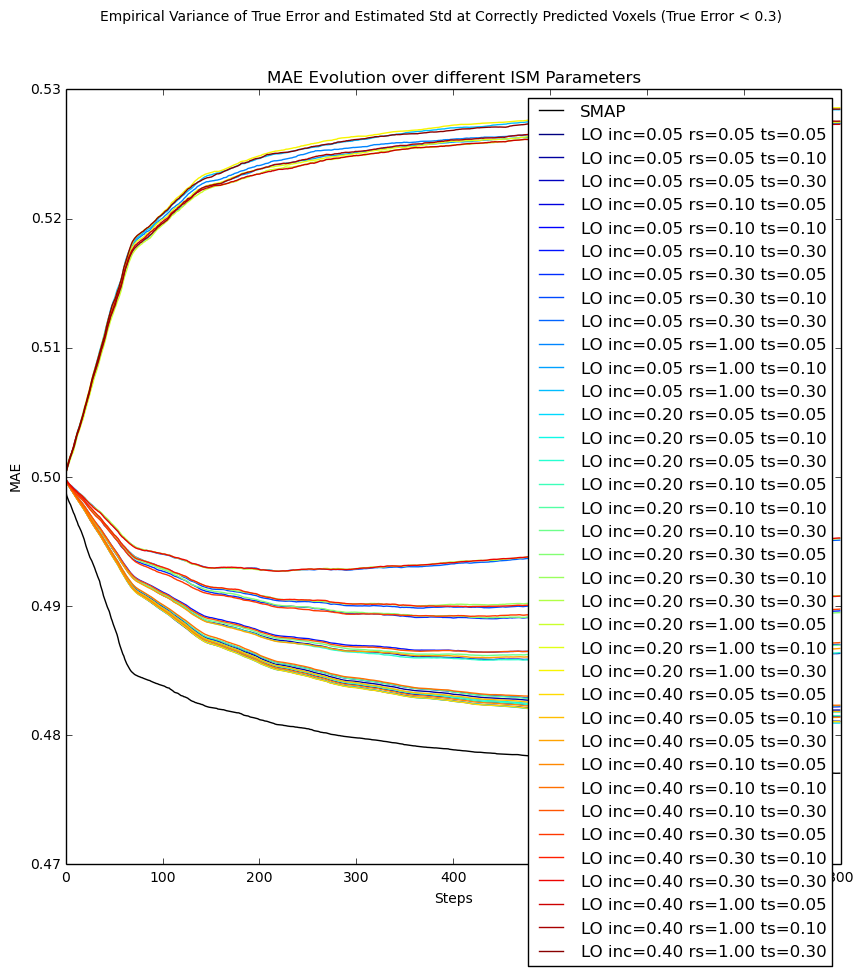

In [12]:
%matplotlib inline
fig, ((ax)) = plt.subplots(1, 1, figsize=(10, 10))
fig.suptitle("Empirical Variance of True Error and Estimated Std at Correctly Predicted Voxels (True Error < 0.3)")

# size is rounds * step
updated_voxels = []
err_belief = []
std_belief = []
err_logodds = []
std_logodds = []

steps = 0
voxels = 0

last_stats = None

# see octomap::OcTreeKey::KeyHash
def hash_position(x, y, z):
    return "%.3f %.3f %.3f" % (x, y, z)

filenames = sorted(
    glob.glob("../build/ism_runs/*.bag"),
    key=lambda f: int(re.findall('([0-9]+)', f[len("../build/ism_runs/"):])[0]))

gradient = np.linspace(0, 0.99, len(filenames))
colors = [cm.jet(x) for x in gradient]

for rnd, filename in enumerate(filenames):
#     print "Computing mask from round %i..." % rnd
    bag = rosbag.Bag(filename)
    stats = None
    for _, msg, _ in bag.read_messages(topics=['stats']):
        stats = msg
    bag.close()
    if stats is None:
        continue
    voxels = stats.voxels
    
    if rnd == 0:
        errBelief = np.array(stats.errorEvolutionBelief)
        ax.plot(errBelief, color="black", label="SMAP")
        
    errLogOdds = np.array(stats.errorEvolutionLogOdds)
    ax.plot(errLogOdds, color=colors[rnd], label="LO inc=%.2f rs=%.2f ts=%.2f" % (stats.ismIncrement, stats.ismRampSize, stats.ismTopSize))
    
ax.set_title("MAE Evolution over different ISM Parameters")
ax.set_ylabel("MAE")
ax.set_xlabel("Steps")
ax.legend()

Smap Inconsistency: 2035.62056577


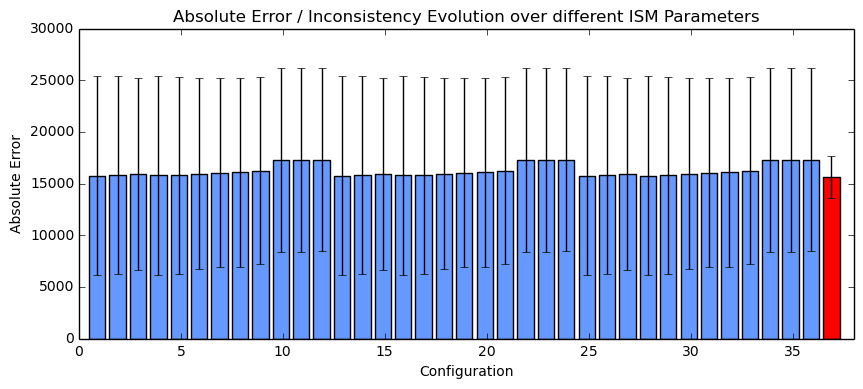

In [46]:
%matplotlib inline
fig, ((ax)) = plt.subplots(1, 1, figsize=(10, 4))

# size is rounds * step
updated_voxels = []
err_belief = []
std_belief = []
err_logodds = []
std_logodds = []

steps = 0
voxels = 0

last_stats = None

# see octomap::OcTreeKey::KeyHash
def hash_position(x, y, z):
    return "%.3f %.3f %.3f" % (x, y, z)

filenames = sorted(
    glob.glob("../build/ism_runs/*.bag"),
    key=lambda f: int(re.findall('([0-9]+)', f[len("../build/ism_runs/"):])[0]))

gradient = np.linspace(0, 0.99, len(filenames))
colors = [cm.jet(x) for x in gradient]
colors[-1] = "red"

inconsistencies = []
labels = []
errors = []
smapInconsistency = 0
smapError = 0
for rnd, filename in enumerate(filenames):
#     print "Computing mask from round %i..." % rnd
    bag = rosbag.Bag(filename)
    stats = None
    for _, msg, _ in bag.read_messages(topics=['stats']):
        stats = msg
    bag.close()
    if stats is None:
        continue
    voxels = stats.voxels
    
#     if rnd == 0:
#         errBelief = np.array(stats.errorEvolutionBelief)
#         ax.plot(errBelief, color="black", label="SMAP")
        
    errLogOdds = np.array(stats.errorLogOdds)
    stdLogOdds = np.array(stats.stdLogOdds)
    scaling_logodds = 0.32757233556747717 # check SMAP Repeated Runs
    k = 1
    inconsistencies.append(np.sum([max(0, err - k * scaling_logodds * std) for err, std in zip(errLogOdds, stdLogOdds)]))
    errors.append(stats.errorEvolutionLogOdds[-1]*voxels)
    label = "LO inc=%.2f rs=%.2f ts=%.2f" % (stats.ismIncrement, stats.ismRampSize, stats.ismTopSize)
    labels.append(label)
    #ax.plot(errLogOdds, color=colors[rnd], label=label)
    
    if rnd == len(filenames)-1:
        smapError = stats.errorEvolutionBelief[-1]*voxels
        errBelief = np.array(stats.errorBelief)
        stdBelief = np.array(stats.stdBelief)
        smapInconsistency = np.sum([max(0, err - k * std) for err, std in zip(errBelief, stdBelief)])
        print "Smap Inconsistency:", smapInconsistency

ax.bar(np.array(list(range(len(errors))))+.5, errors, yerr=inconsistencies, color="#6699ff", ecolor="black")
# for i, (inconsistency, error, label) in enumerate(zip(inconsistencies, errors, labels)):
#     ax.bar([i], [error], yerr=[inconsistency])

ax.bar([len(errors)+.5], [smapError], yerr=[smapInconsistency], color="r", ecolor="black")
    
ax.set_title("Absolute Error / Inconsistency Evolution over different ISM Parameters")
ax.set_ylabel("Absolute Error")
ax.set_xlabel("Configuration")
ax.set_xlim([0,len(errors)+2])
ax.legend()